https://radimrehurek.com/data_science_python/

#### Import modules

In [268]:
from textblob.classifiers import NaiveBayesClassifier
from textblob import TextBlob
import random
import time
import os
import sys
import os.path
import string

# ---- for TF-IDF & NLTK
import math
from textblob import TextBlob as tb
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from pathlib import Path
from beautifultable import BeautifulTable

import re, string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from tabulate import tabulate

allRunsAccuracy = []

import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

#### The rest

#### First, randomize the dataset by getting 200 out of the 250 values per class which is equal to 1/5th of the dataset, every time it is different so we can output different results and get average performance values

In [269]:
file = open(r"C:\Users\ani\Dropbox\Stuff\university\data\250PerClass.txt", 'r', encoding = "ISO-8859-1")
sentences = file.read().split('\n')

CD,CM,AP,SM,EX = 0,0,0,0,0
print(len(sentences))

with open(r"C:\Users\ani\Dropbox\Stuff\university\data\200RandomPerClass.csv", 'w', encoding = "ISO-8859-1") as oFile:
    while len(sentences) >= 250:
        curLine = random.choice(sentences)
        curLineParts = curLine.split("|")

        if curLineParts[0] == "CD" and CD <= 200:
            sentences.remove(curLine)
            oFile.write(curLineParts[0]+"|"+curLineParts[1]+"\n")
            CD += 1
        elif curLineParts[0] == "CM" and CM <= 200:
            sentences.remove(curLine)
            oFile.write(curLineParts[0]+"|"+curLineParts[1]+"\n")
            CM += 1
        elif curLineParts[0] == "AP" and AP <= 200:
            sentences.remove(curLine)
            oFile.write(curLineParts[0]+"|"+curLineParts[1]+"\n")
            AP += 1
        elif curLineParts[0] == "SM" and SM <= 200:
            sentences.remove(curLine)
            oFile.write(curLineParts[0]+"|"+curLineParts[1]+"\n")
            SM += 1
        elif curLineParts[0] == "EX" and EX <= 200:
            sentences.remove(curLine)
            oFile.write(curLineParts[0]+"|"+curLineParts[1]+"\n")
            EX += 1
                
print(len(sentences))
print(CD,"\t",CM,"\t",AP,"\t",SM,"\t",EX)

1250
249
201 	 201 	 198 	 201 	 200


#### Now off to the rest

In [270]:
# ADD THE FILE THAT IS NOT PREPROCESSED YET
prefix = r"C:\Users\ani"
sentences = pandas.read_csv(prefix + r'\Dropbox\Stuff\university\data\200RandomPerClass.csv', sep='|', quoting=csv.QUOTE_NONE,
                           names=["Label", "Sentence"], encoding = "ISO-8859-1")
print(sentences[:10]) 

  Label                                           Sentence
0    CM         however,let's talk about the inputs first 
1    SM        that's the fundamental theorem of calculus 
2    EX  these are two places where the derivative is e...
3    CM                               let's get rid of it 
4    AP  you can use OMITTED it's always smooth,if you ...
5    EX                      the graph is always wiggling 
6    EX  if we knew where those degrees were granted,sa...
7    CM  a processing element is a digital device,which...
8    CM  let's examine the minimum ram and rom required...
9    CM                       what happens at the bounces 


In [271]:
sentences.groupby('Label').describe()

Sentence                                                               
         count unique                                                top freq
Label                                                                        
AP         198    198   we could also change the release and the attack     1
CD         201    201  this is a graph of a function the input to thi...    1
CM         201    201  so,we would like the height to be less than or...    1
EX         200    200     what are the critical points of this function     1
SM         201    201                   the input change by some factor     1

  Label                                           Sentence  length
0    CM         however,let's talk about the inputs first       42
1    SM        that's the fundamental theorem of calculus       43
2    EX  these are two places where the derivative is e...      59
3    CM                               let's get rid of it       20
4    AP  you can use OMITTED it's always smooth,if you ...     107


[]


Text(0,0.5,'Quantity')

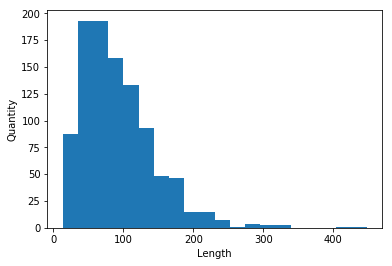

In [272]:
sentences['length'] = sentences['Sentence'].map(lambda text: len(text))
print(sentences.head())

sentences.length.plot(bins=20, kind='hist')

print("\n")
sentences.length.describe()
print(list(sentences.Sentence[sentences.length > 500]))

#sentences.hist(column='length', by='Label', bins='auto',figsize=(10, 15), color="c")
plt.xlabel('Length')
plt.ylabel('Quantity')

In [273]:
#split a sent into its individual words
def split_into_tokens(sent):
    #sent = unicode(sent, 'utf8')  # convert bytes into proper unicode
    return TextBlob(sent).words

sentences.Sentence.apply(split_into_tokens)

0       [however, let, 's, talk, about, the, inputs, f...
1       [that, 's, the, fundamental, theorem, of, calc...
2       [these, are, two, places, where, the, derivati...
3                             [let, 's, get, rid, of, it]
4       [you, can, use, OMITTED, it, 's, always, smoot...
5                      [the, graph, is, always, wiggling]
6       [if, we, knew, where, those, degrees, were, gr...
7       [a, processing, element, is, a, digital, devic...
8       [let, 's, examine, the, minimum, ram, and, rom...
9                       [what, happens, at, the, bounces]
10      [but, maybe, it, 's, not, a, trick, because, i...
11      [music, we, 've, seen, df/OMITTED, and, we, 'v...
12      [that, 's, the, sense, in, which, the, instant...
13      [and, then, you, have, to, figure, out, the, p...
14      [when, the, ball, leaves, my, hand, it, 's, go...
15      [this, means, that, the, data, should, be, in,...
16      [finally, it, 's, just, a, matter, of, evaluat...
17      [all, 

In [274]:
# pre-processing
def split_into_lemmas(sent):
    words = TextBlob(sent).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

sentences.Sentence.head().apply(split_into_lemmas)

0    [however, let, 's, talk, about, the, input, fi...
1    [that, 's, the, fundamental, theorem, of, calc...
2    [these, are, two, place, where, the, derivativ...
3                          [let, 's, get, rid, of, it]
4    [you, can, use, OMITTED, it, 's, always, smoot...
Name: Sentence, dtype: object

In [275]:
# Data to vectors

# convert each message, represented as a list of tokens (lemmas) above, 
# into a vector that machine learning models can understand

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(sentences['Sentence'])
print(len(bow_transformer.vocabulary_))

1938


In [276]:
#message1000 = sentences['Sentence'][999]
#print(message1000)
#
#bow1000 = bow_transformer.transform([message1000])
#print(bow1000)
#print(bow1000.shape)
#print("OMITTED appears 3 times, i appears twice etc")

featureList = bow_transformer.get_feature_names()
finalFeatureList = []

def removeNumsFromFeatureList(featureList):
    isNum = re.compile("[0-9]")
    hasApostrophe = re.compile("'\w+")
        
    for feat in featureList:
        if isNum.match(feat): pass
        elif hasApostrophe.match(feat): pass
        elif "OMITTED" in feat.upper(): pass
        elif "NUMBER" in feat.upper(): pass
        elif ("-" or "+") in feat.upper(): pass
        else: finalFeatureList.append(feat)

print("Nr of features: ",len(featureList))
removeNumsFromFeatureList(featureList)
print("Nr of features after cleaning: ",len(finalFeatureList))

#print(bow_transformer.get_feature_names()[5214])

Nr of features:  1938
Nr of features after cleaning:  1889


In [277]:
sentences_bow = bow_transformer.transform(sentences['Sentence'])
print('sparse matrix shape:', sentences_bow.shape)
print('number of non-zeros:', sentences_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * sentences_bow.nnz / (sentences_bow.shape[0] * sentences_bow.shape[1])))

#after the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(sentences_bow)
#tfidf1000 = tfidf_transformer.transform(bow1000)
#print(tfidf1451)

# To transform the entire bag-of-words corpus into TF-IDF corpus at once:
sentences_tfidf = tfidf_transformer.transform(sentences_bow)
print(sentences_tfidf.shape)

sparse matrix shape: (1001, 1938)
number of non-zeros: 14731
sparsity: 0.76%
(1001, 1938)


### RUN THE CLASSIFIER!

In [278]:
# Using Multinomial Naive Bayes classifier
%time label_classifier = MultinomialNB().fit(sentences_tfidf, sentences['Label'].fillna(""))

Wall time: 7.99 ms


In [279]:
#print('Predicted:', label_classifier.predict(tfidf1000)[0])
#print('Actual:', sentences.Label[999])

In [280]:
all_predictions = label_classifier.predict(sentences_tfidf)
#print(all_predictions)

print('\n========Confusion matrix=========\n', confusion_matrix(sentences['Label'].fillna(""), all_predictions))
print('(row=Actual, col=Predicted)')

print("\n_______________Multinomial Naive Bayes________________\n")
print(classification_report(sentences['Label'].fillna(""), all_predictions))
print('Accuracy:\t {0:.2f}'.format(accuracy_score(sentences['Label'].fillna(""), all_predictions)))
print("______________________________________________________\n")


========Confusion matrix=========
 [[163  11   2  13   9]
 [  0 178   0  16   7]
 [ 10  14 155   7  15]
 [  6  14   0 174   6]
 [  4   7   1  12 177]]
(row=Actual, col=Predicted)

_______________Multinomial Naive Bayes________________

             precision    recall  f1-score   support

         AP       0.89      0.82      0.86       198
         CD       0.79      0.89      0.84       201
         CM       0.98      0.77      0.86       201
         EX       0.78      0.87      0.82       200
         SM       0.83      0.88      0.85       201

avg / total       0.86      0.85      0.85      1001

Accuracy:	 0.85
______________________________________________________

